# Returning to the issue of car mileage during covid

This is due to people re-using registration numbers...

In [21]:
import pandas_gbq
from google.oauth2 import service_account
import os
# from google.cloud import bigquery
import tqdm
import seaborn as sns
from matplotlib import pyplot as plt
import datetime as dt
import pandas as pd
from tqdm import tqdm

In [22]:
# Credentials for BigQuery
credentials = service_account.Credentials.from_service_account_file('rugged-baton-283921-5706f65c85fe.json')

This query will find all the MOT tests carried out in March 2021, and extract the list of registration numbers. It will then find the intersection of those registrations and the `mot.vehicles` table, which contains all the vehicle data. We select a random selection of 100 of those vehicles & their tests (by using `ORDER BY rand()` and `LIMT 100`. 

In [156]:
sql = """
WITH registrations as(
    SELECT registration as reg
    FROM `rugged-baton-283921.mots.tests`
    WHERE EXTRACT(YEAR from completedDate) > 2020
    AND EXTRACT(MONTH from completedDate) > 1
    AND testResult = "PASSED"
    GROUP BY registration
), vehicles as (
    SELECT *
    FROM `rugged-baton-283921.mots.vehicles` B
    RIGHT JOIN registrations A
    ON B.registration = A.reg
    WHERE EXTRACT(YEAR from B.firstUsedDate) < 2015
    AND EXTRACT(YEAR from B.firstUsedDate) > 2010
    ORDER BY rand()
    LIMIT 100
) SELECT *
FROM `rugged-baton-283921.mots.tests` A
INNER JOIN vehicles B 
ON A.registration = B.registration
AND A.completedDate > B.firstUsedDate
WHERE A.testResult = "PASSED";
"""

In [157]:
df = pandas_gbq.read_gbq(sql, project_id='rugged-baton-283921', credentials = credentials, progress_bar_type='tqdm')

Downloading: 100%|████████████████████████████████████████████████████████████████| 296/296 [00:00<00:00, 862.80rows/s]


In [158]:
df = df[df['odometerValue'] < 200000]

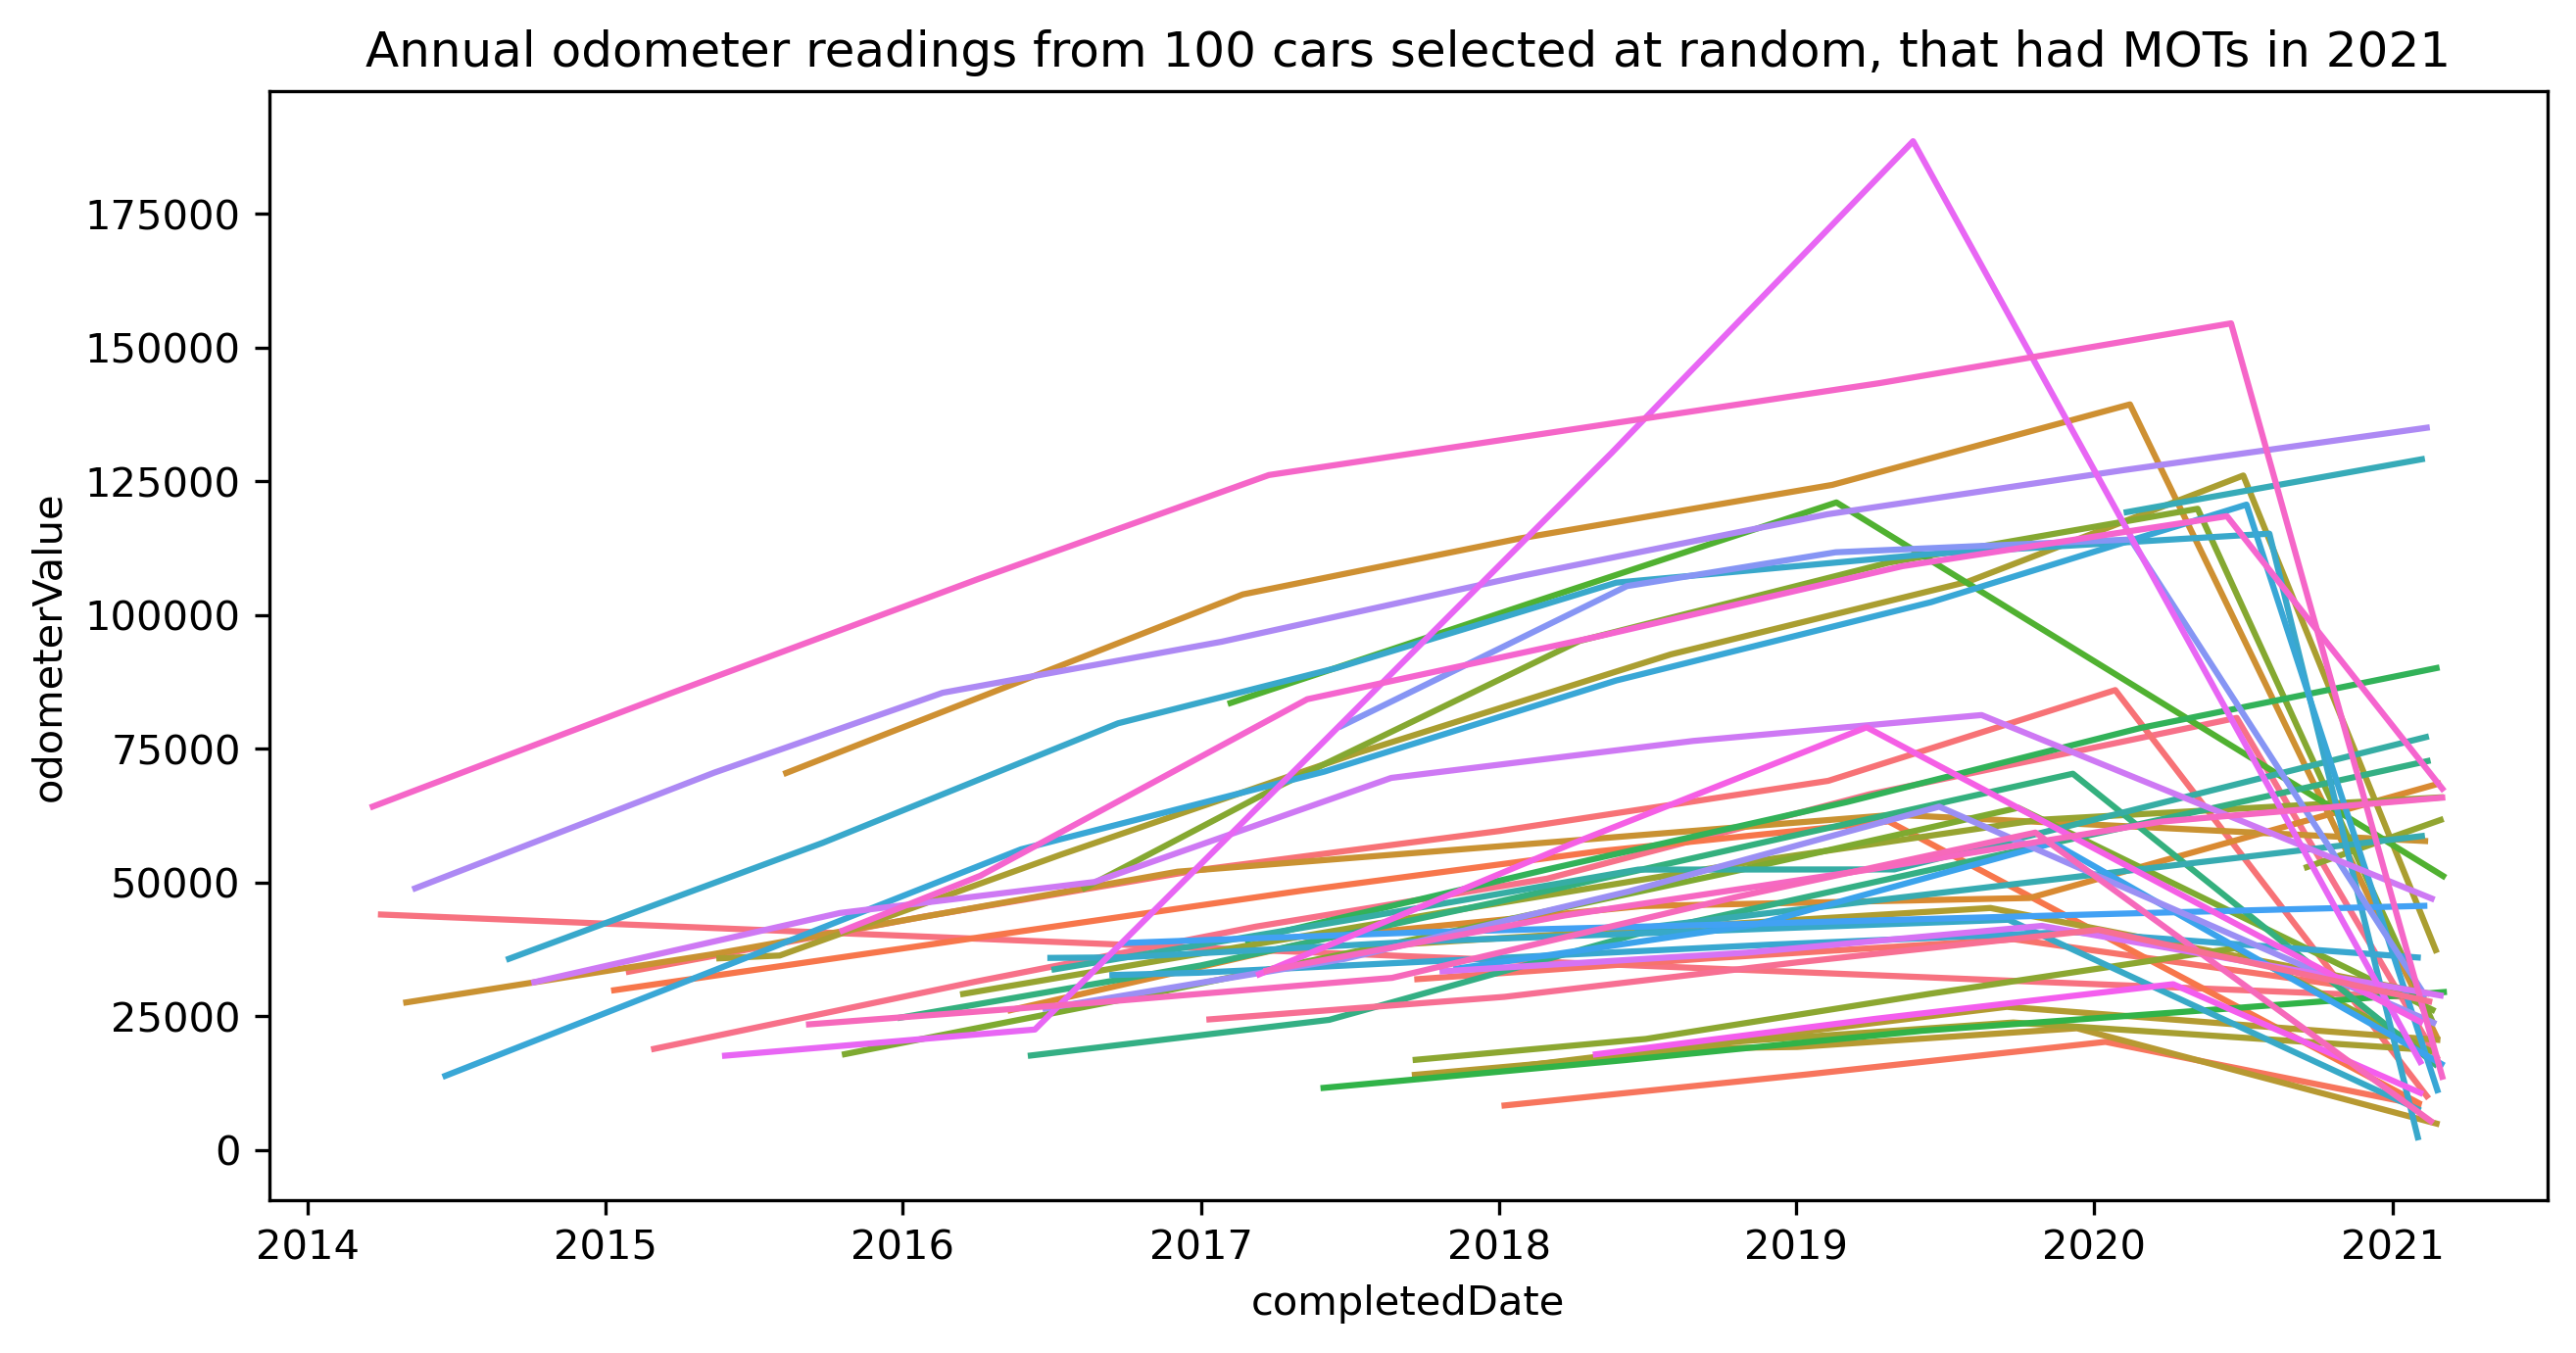

In [159]:
# Plot the results of our query, and have a look... 

plt.figure(figsize=(10, 5), dpi=300)
plt.title('Annual odometer readings from 100 cars selected at random, that had MOTs in 2021')
sns.lineplot(data = df, x='completedDate', y='odometerValue', hue='registration', legend=False)
plt.savefig('first_attempt_annual_mileage')

Something has gone **very, very wrong**!!

In [160]:
#We've got a few too many data points, let's look at those where we have the most records for each individual vehicle...
regs = df.registration.value_counts()[:20].index.to_list()
regs

['WF14FKB',
 'S10BNR',
 'D7RLO',
 'AVS4',
 'W4ONY',
 'D12GWP',
 'K77SML',
 'P888APA',
 'LU13NAW',
 'F6AJR',
 'D15SJO',
 'E16GAK',
 'DE61HUT',
 'L800DAY',
 'ST04OPM',
 'H5KNM',
 'A12NCA',
 'H9ULE',
 'P1TNE',
 'HB14NCH']

In [161]:
#df2 is a df comprising the 20 vehicles in df which have the most MOT test records. 

df2 = df[df['registration'].isin(regs)]

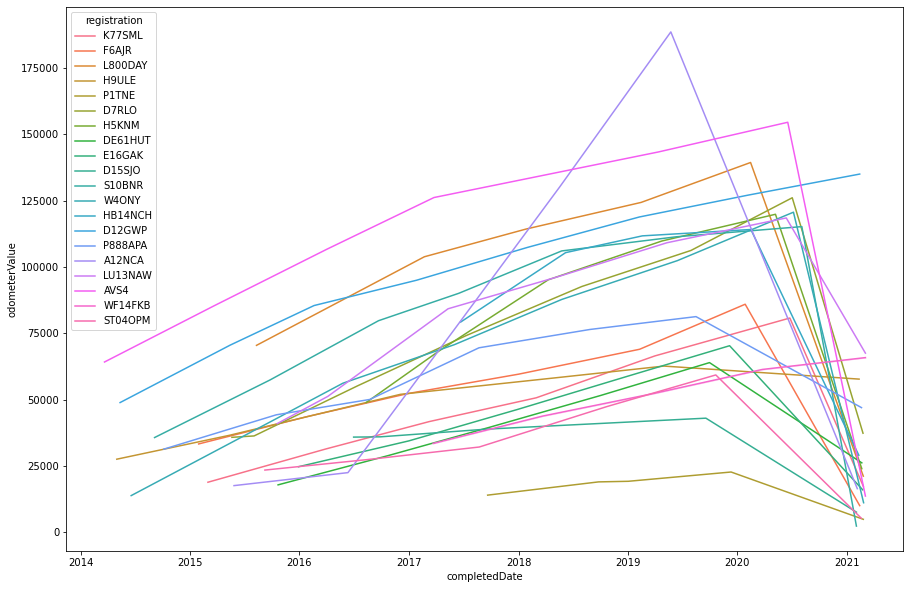

<Figure size 432x288 with 0 Axes>

In [162]:
plt.figure(figsize=(15, 10))
sns.lineplot(data = df2, x='completedDate', y='odometerValue', hue='registration')
plt.show()
plt.savefig('weirdness.jpg')

**Gah!!** What on earth is going on? Odometer readings can either plateau, stop, or go up. **They must never go down**

In [163]:
df2[df2['registration'] == regs[1]].sort_values('completedDate')

,completedDate,testResult,expiryDate,odometerValue,odometerUnit,motTestNumber,odometerResultType,registration,jsonPage,registration_1,...,model,firstUsedDate,registrationDate,manufactureDate,engineSize,fuelType,primaryColour,vehicleId,jsonPage_1,reg
123,2014-09-05 00:00:00+00:00,PASSED,2015-09-16 00:00:00+00:00,35728,mi,505298644272,READ,S10BNR,28992.json,S10BNR,...,BERLINGO,2011-09-16 00:00:00+00:00,2011-09-16 00:00:00+00:00,2011-09-16 00:00:00+00:00,1560.0,Diesel,White,J_SjXZ0H0at7Kutpr6AU6A==,28992.json,S10BNR
122,2015-09-25 00:00:00+00:00,PASSED,2016-09-24 00:00:00+00:00,57420,mi,290313395034,READ,S10BNR,28992.json,S10BNR,...,BERLINGO,2011-09-16 00:00:00+00:00,2011-09-16 00:00:00+00:00,2011-09-16 00:00:00+00:00,1560.0,Diesel,White,J_SjXZ0H0at7Kutpr6AU6A==,28992.json,S10BNR
121,2016-09-21 00:00:00+00:00,PASSED,2017-09-24 00:00:00+00:00,79752,mi,628619076140,READ,S10BNR,28992.json,S10BNR,...,BERLINGO,2011-09-16 00:00:00+00:00,2011-09-16 00:00:00+00:00,2011-09-16 00:00:00+00:00,1560.0,Diesel,White,J_SjXZ0H0at7Kutpr6AU6A==,28992.json,S10BNR
120,2017-06-16 00:00:00+00:00,PASSED,2018-06-15 00:00:00+00:00,90092,mi,585738019695,READ,S10BNR,28992.json,S10BNR,...,BERLINGO,2011-09-16 00:00:00+00:00,2011-09-16 00:00:00+00:00,2011-09-16 00:00:00+00:00,1560.0,Diesel,White,J_SjXZ0H0at7Kutpr6AU6A==,28992.json,S10BNR
119,2018-05-25 00:00:00+00:00,PASSED,2019-06-15 00:00:00+00:00,106047,mi,803619512243,READ,S10BNR,28992.json,S10BNR,...,BERLINGO,2011-09-16 00:00:00+00:00,2011-09-16 00:00:00+00:00,2011-09-16 00:00:00+00:00,1560.0,Diesel,White,J_SjXZ0H0at7Kutpr6AU6A==,28992.json,S10BNR
118,2019-06-12 00:00:00+00:00,PASSED,2020-07-29 00:00:00+00:00,111384,mi,614771495127,READ,S10BNR,28992.json,S10BNR,...,BERLINGO,2011-09-16 00:00:00+00:00,2011-09-16 00:00:00+00:00,2011-09-16 00:00:00+00:00,1560.0,Diesel,White,J_SjXZ0H0at7Kutpr6AU6A==,28992.json,S10BNR
117,2020-08-03 00:00:00+00:00,PASSED,2021-08-02 00:00:00+00:00,115204,mi,991890809689,READ,S10BNR,28992.json,S10BNR,...,BERLINGO,2011-09-16 00:00:00+00:00,2011-09-16 00:00:00+00:00,2011-09-16 00:00:00+00:00,1560.0,Diesel,White,J_SjXZ0H0at7Kutpr6AU6A==,28992.json,S10BNR
74,2021-02-01 00:00:00+00:00,PASSED,2022-01-31 00:00:00+00:00,2364,mi,952063498684,READ,S10BNR,137722.json,S10BNR,...,BERLINGO,2011-09-16 00:00:00+00:00,2011-09-16 00:00:00+00:00,2011-09-16 00:00:00+00:00,1560.0,Diesel,White,J_SjXZ0H0at7Kutpr6AU6A==,28992.json,S10BNR


Turns out the problem is **reused registration numbers**. So when we select a VRN and match it to old MOT test records, we're getting the older vehicle, and all the old vehicle's results, plus the latest new MOT added in, which is making our data... er... problematic. 

### How to filter out reused registrations

We'll explore the issue of re-used registrations a bit more in notebook number 3. Here, we'll try some quick fixes to our SQL query to see if we can't get rid of them...

Here's our original SQL query, but with a line of code added into the final `WHERE` clause: `AND B.odo >= A.odometerValue`. This filters out any test results that have a lower odometerReading than our latest test result carried out in march.

In [164]:
sql = """
WITH registrations as(
    SELECT registration as reg, MAX(odometerValue) as odo
    FROM `rugged-baton-283921.mots.tests`
    WHERE EXTRACT(YEAR from completedDate) = 2021
    AND EXTRACT(MONTH from completedDate) > 1
    AND testResult = "PASSED"
    GROUP BY registration
), vehicles as (
    SELECT *
    FROM `rugged-baton-283921.mots.vehicles` B
    RIGHT JOIN registrations A
    ON B.registration = A.reg
    WHERE EXTRACT(YEAR from B.firstUsedDate) < 2015
    AND EXTRACT(YEAR from B.firstUsedDate) > 2010
) SELECT *
FROM `rugged-baton-283921.mots.tests` A
INNER JOIN vehicles B 
ON A.registration = B.registration
AND A.completedDate > B.firstUsedDate
WHERE A.testResult = "PASSED"
AND B.odo >= A.odometerValue;
"""

In [165]:
df = pandas_gbq.read_gbq(sql, project_id='rugged-baton-283921', credentials = credentials, progress_bar_type='tqdm')

Downloading: 100%|█████████████████████████████████████████████████████████████| 2900/2900 [00:01<00:00, 1817.93rows/s]


<AxesSubplot:xlabel='completedDate', ylabel='odometerValue'>

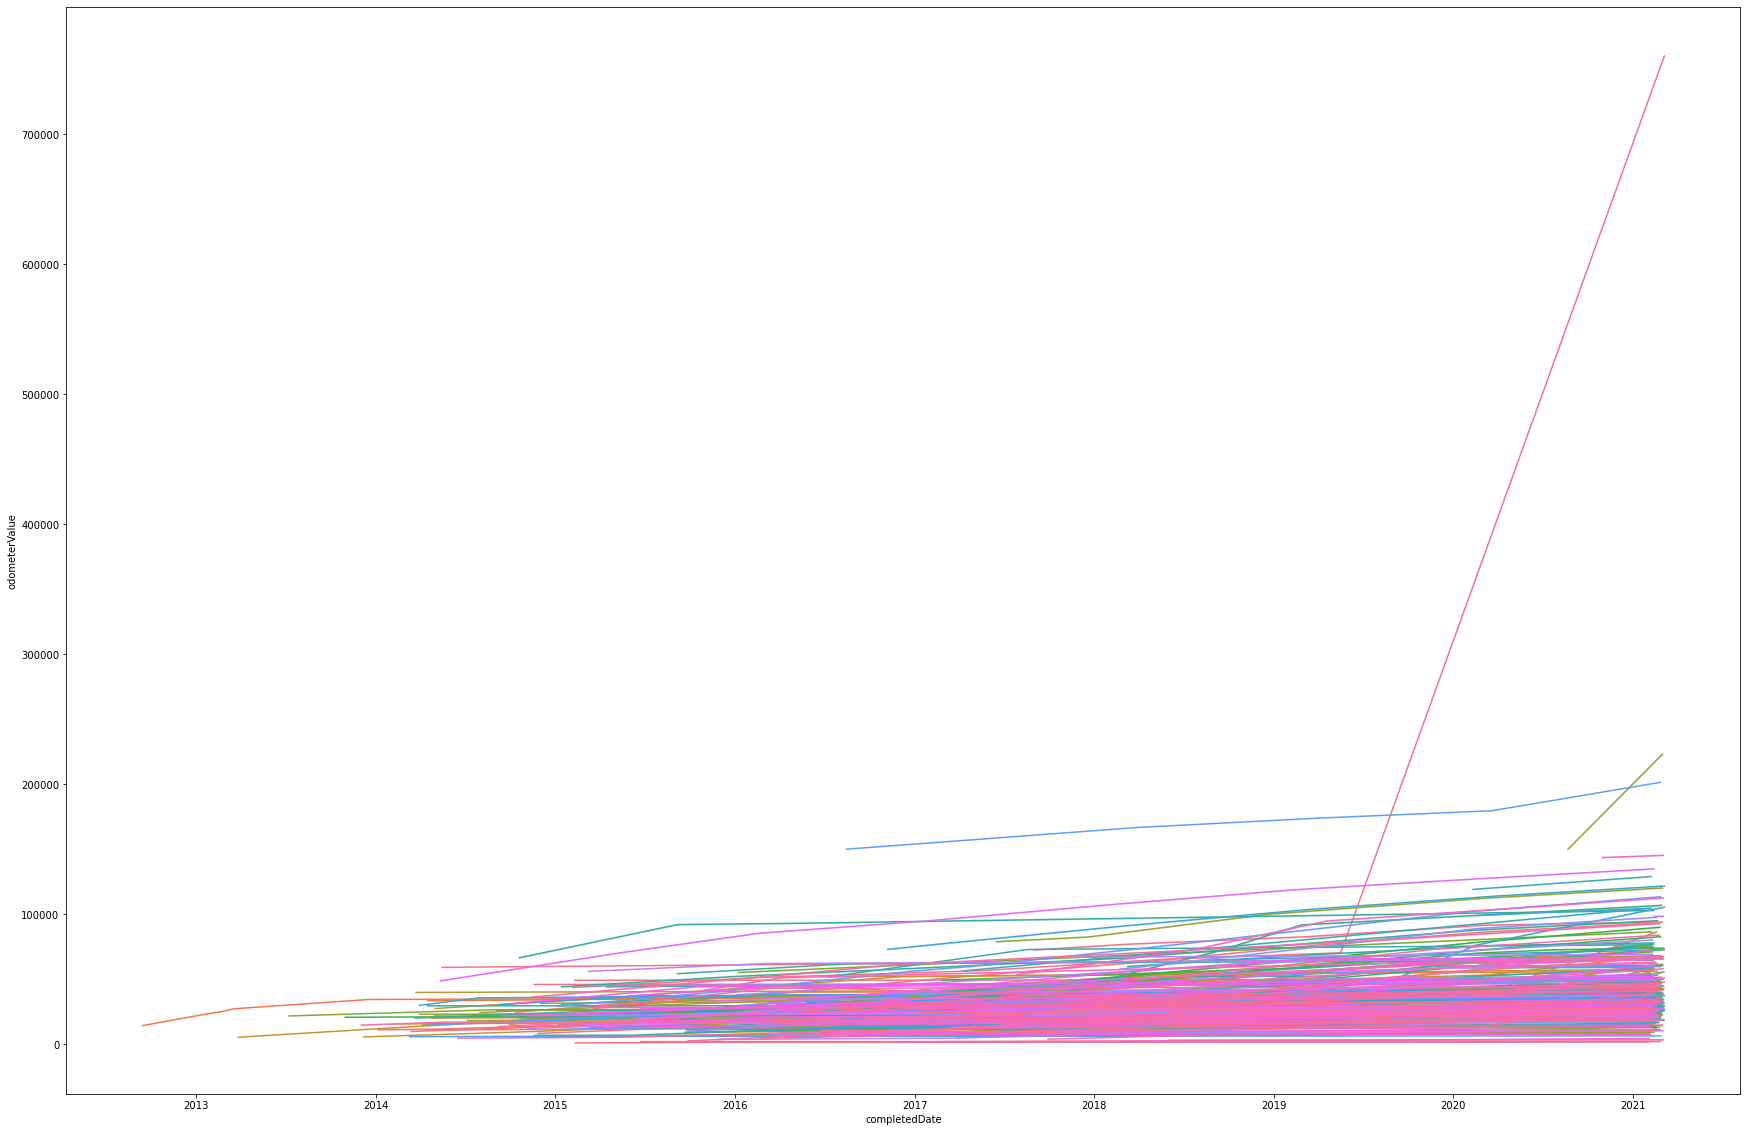

In [166]:
plt.figure(figsize=(30, 20))
sns.lineplot(data = df, x='completedDate', y='odometerValue', hue='registration', legend=False)

We probably have more vehicles in this dataset than is helpful to try to work with. The graph is a mess, and skewed by one or two other, very problematic odometerValue readings...

Since we just want to sample some vehicles and look for a covid factor, let's take the top 20 vehicles with the most MOT tests to their name.

In [187]:
regs = df.registration.value_counts().index.to_list()
# regs

In [168]:
df2 = df[df['registration'].isin(regs)]

That looks **way better**. Yes, some problematic ones, but mostly the lines do what we'd expect. 

In [169]:
df2.sort_values('completedDate', ascending=False)

,completedDate,testResult,expiryDate,odometerValue,odometerUnit,motTestNumber,odometerResultType,registration,jsonPage,registration_1,...,firstUsedDate,registrationDate,manufactureDate,engineSize,fuelType,primaryColour,vehicleId,jsonPage_1,reg,odo
1232,2021-03-05 00:00:00+00:00,PASSED,2022-03-04 00:00:00+00:00,37536,mi,751156491540,READ,GX11NXH,137663.json,GX11NXH,...,2011-06-29 00:00:00+00:00,2011-06-29 00:00:00+00:00,2011-06-29 00:00:00+00:00,1390.0,Petrol,Silver,-sCdQU6juDqXw5zMypSu6A==,137663.json,GX11NXH,37536
1235,2021-03-05 00:00:00+00:00,PASSED,2022-03-04 00:00:00+00:00,8373,mi,967179966349,READ,12695,138285.json,12695,...,2014-01-31 00:00:00+00:00,2014-01-31 00:00:00+00:00,2014-01-31 00:00:00+00:00,1500.0,Hybrid Electric (Clean),Bronze,e8B0A09Qs_Nu-dPpM2VeXw==,138285.json,12695,8373
1230,2021-03-05 00:00:00+00:00,PASSED,2022-03-04 00:00:00+00:00,121822,mi,840362630321,READ,AB11LLJ,138284.json,AB11LLJ,...,2013-12-03 00:00:00+00:00,2013-12-03 00:00:00+00:00,2013-12-03 00:00:00+00:00,1598.0,Diesel,Blue,z2tiXXl8bEET6HPNHgzE0Q==,112197.json,AB11LLJ,121822
255,2021-03-05 00:00:00+00:00,PASSED,2022-03-13 00:00:00+00:00,29134,mi,396879963561,READ,WO07DJA,138263.json,WO07DJA,...,2012-09-19 00:00:00+00:00,2012-09-19 00:00:00+00:00,2012-09-19 00:00:00+00:00,2993.0,Diesel,White,OQxT8FrfH3kO7ce3Qb6CpQ==,99373.json,WO07DJA,29134
1231,2021-03-05 00:00:00+00:00,PASSED,2022-03-04 00:00:00+00:00,14558,mi,841060653852,READ,YN64ZXT,138284.json,YN64ZXT,...,2014-09-30 00:00:00+00:00,2014-09-30 00:00:00+00:00,2014-09-30 00:00:00+00:00,1797.0,Hybrid Electric (Clean),Black,vn-d4-4yCK8CZHIQaxn8WA==,138284.json,YN64ZXT,14558
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1950,2013-03-28 00:00:00+00:00,PASSED,2014-03-27 00:00:00+00:00,5501,mi,997557883010,READ,JIM5,20915.json,JIM5,...,2013-01-18 00:00:00+00:00,2013-01-18 00:00:00+00:00,2013-01-18 00:00:00+00:00,2987.0,Diesel,Silver,Ok39mSiiXOIOazJP2Bcjpw==,20915.json,JIM5,61164
2421,2013-03-19 00:00:00+00:00,PASSED,2014-03-18 00:00:00+00:00,27403,mi,677318273084,READ,D14SLC,85795.json,D14SLC,...,2011-09-20 00:00:00+00:00,2011-09-20 00:00:00+00:00,2011-09-20 00:00:00+00:00,2993.0,Diesel,Black,GWSz8VzMSOptfzlYIVVw_g==,85795.json,D14SLC,37890
2422,2013-02-20 00:00:00+00:00,PASSED,2014-02-19 00:00:00+00:00,25043,mi,325191953053,READ,D14SLC,85795.json,D14SLC,...,2011-09-20 00:00:00+00:00,2011-09-20 00:00:00+00:00,2011-09-20 00:00:00+00:00,2993.0,Diesel,Black,GWSz8VzMSOptfzlYIVVw_g==,85795.json,D14SLC,37890
2423,2013-01-18 00:00:00+00:00,PASSED,2014-01-17 00:00:00+00:00,23118,mi,758208213059,READ,D14SLC,85795.json,D14SLC,...,2011-09-20 00:00:00+00:00,2011-09-20 00:00:00+00:00,2011-09-20 00:00:00+00:00,2993.0,Diesel,Black,GWSz8VzMSOptfzlYIVVw_g==,85795.json,D14SLC,37890


### Now to measure *change* in annual mileage. For every registration, we need to measure how many additional miles are being driven in the period between each test. 

Let's start by simplifying things and getting rid of some values that we don't really need. 

In [170]:
# We can come back to df3 to look at makes/models, etc. 
df3 = df2[['completedDate', 'odometerValue', 'registration', 'fuelType', 'make', 'primaryColour']]

In [171]:
# df_g is a grouped dataframe
df_g = df3.groupby(['registration', 'completedDate']).mean()
df_g.reset_index(inplace=True)
df_g.set_index(['registration'])
# df_g.head(15)

,completedDate,odometerValue
registration,,
0968KVF,2021-03-05 00:00:00+00:00,70049
09D122250,2021-03-04 00:00:00+00:00,203136
11-C-2880,2021-02-03 00:00:00+00:00,183856
11-C-5326,2021-02-05 00:00:00+00:00,88990
1163KZL,2021-02-12 00:00:00+00:00,59462
...,...,...
YX61DYF,2021-02-26 00:00:00+00:00,14781
YXB726,2021-02-03 00:00:00+00:00,10980
YY61PUF,2021-02-01 00:00:00+00:00,61206


In [172]:
df_g['time_diff'] = df_g.groupby(['registration'])['completedDate'].diff()

In [173]:
df_g['mile_diff'] = df_g.groupby(['registration'])['odometerValue'].diff()

In [174]:
df_no_na = df_g.dropna()
# df_no_na.head(20)

In [175]:
df_no_na['secs_diff'] = df_no_na.apply(lambda row: row['time_diff'].total_seconds(), axis=1)

<ipython-input-175-f7690483390c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_na['secs_diff'] = df_no_na.apply(lambda row: row['time_diff'].total_seconds(), axis=1)


In [176]:
df_no_na['avg_ann'] = df_no_na.apply(lambda row: (row['mile_diff'] / row['secs_diff'])*31536000, axis=1)

<ipython-input-176-61db501088be>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_na['avg_ann'] = df_no_na.apply(lambda row: (row['mile_diff'] / row['secs_diff'])*31536000, axis=1)


In [177]:
# s = df_no_na.time_diff.dt.total_seconds()

In [178]:
# df_no_na.dtypes

In [179]:
# df_no_na['secs_diff'] = s

In [180]:
df_no_na['avg_ann'] = (df_no_na['mile_diff'] / df_no_na['secs_diff'])*31556952

<ipython-input-180-51546281ba41>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_na['avg_ann'] = (df_no_na['mile_diff'] / df_no_na['secs_diff'])*31556952


Let's try grouping by year, and then averaging.

In [181]:
df_no_na.head()

,registration,completedDate,odometerValue,time_diff,mile_diff,secs_diff,avg_ann
6,11HU,2021-02-26 00:00:00+00:00,38006,1684 days,13175.0,145497600.0,2857.523716
15,12BCG,2016-02-23 00:00:00+00:00,37766,405 days,6867.0,34992000.0,6192.889500
16,12BCG,2021-02-11 00:00:00+00:00,42063,1815 days,4297.0,156816000.0,864.709103
30,151TRT,2021-02-27 00:00:00+00:00,22573,1738 days,2017.0,150163200.0,423.874639
32,171PAL,2016-12-28 00:00:00+00:00,37668,355 days,7752.0,30672000.0,7975.661577


In [182]:
df['completedDate'].iloc[13].year

2015

In [183]:
df_no_na['year'] = df_no_na.apply(lambda row: row['completedDate'].year, axis=1)

<ipython-input-183-6de562bf2783>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_na['year'] = df_no_na.apply(lambda row: row['completedDate'].year, axis=1)


In [184]:
df_no_na = df_no_na[df_no_na['year'] > 2015]
df_no_na.head()

,registration,completedDate,odometerValue,time_diff,mile_diff,secs_diff,avg_ann,year
6,11HU,2021-02-26 00:00:00+00:00,38006,1684 days,13175.0,145497600.0,2857.523716,2021
15,12BCG,2016-02-23 00:00:00+00:00,37766,405 days,6867.0,34992000.0,6192.889500,2016
16,12BCG,2021-02-11 00:00:00+00:00,42063,1815 days,4297.0,156816000.0,864.709103,2021
30,151TRT,2021-02-27 00:00:00+00:00,22573,1738 days,2017.0,150163200.0,423.874639,2021
32,171PAL,2016-12-28 00:00:00+00:00,37668,355 days,7752.0,30672000.0,7975.661577,2016


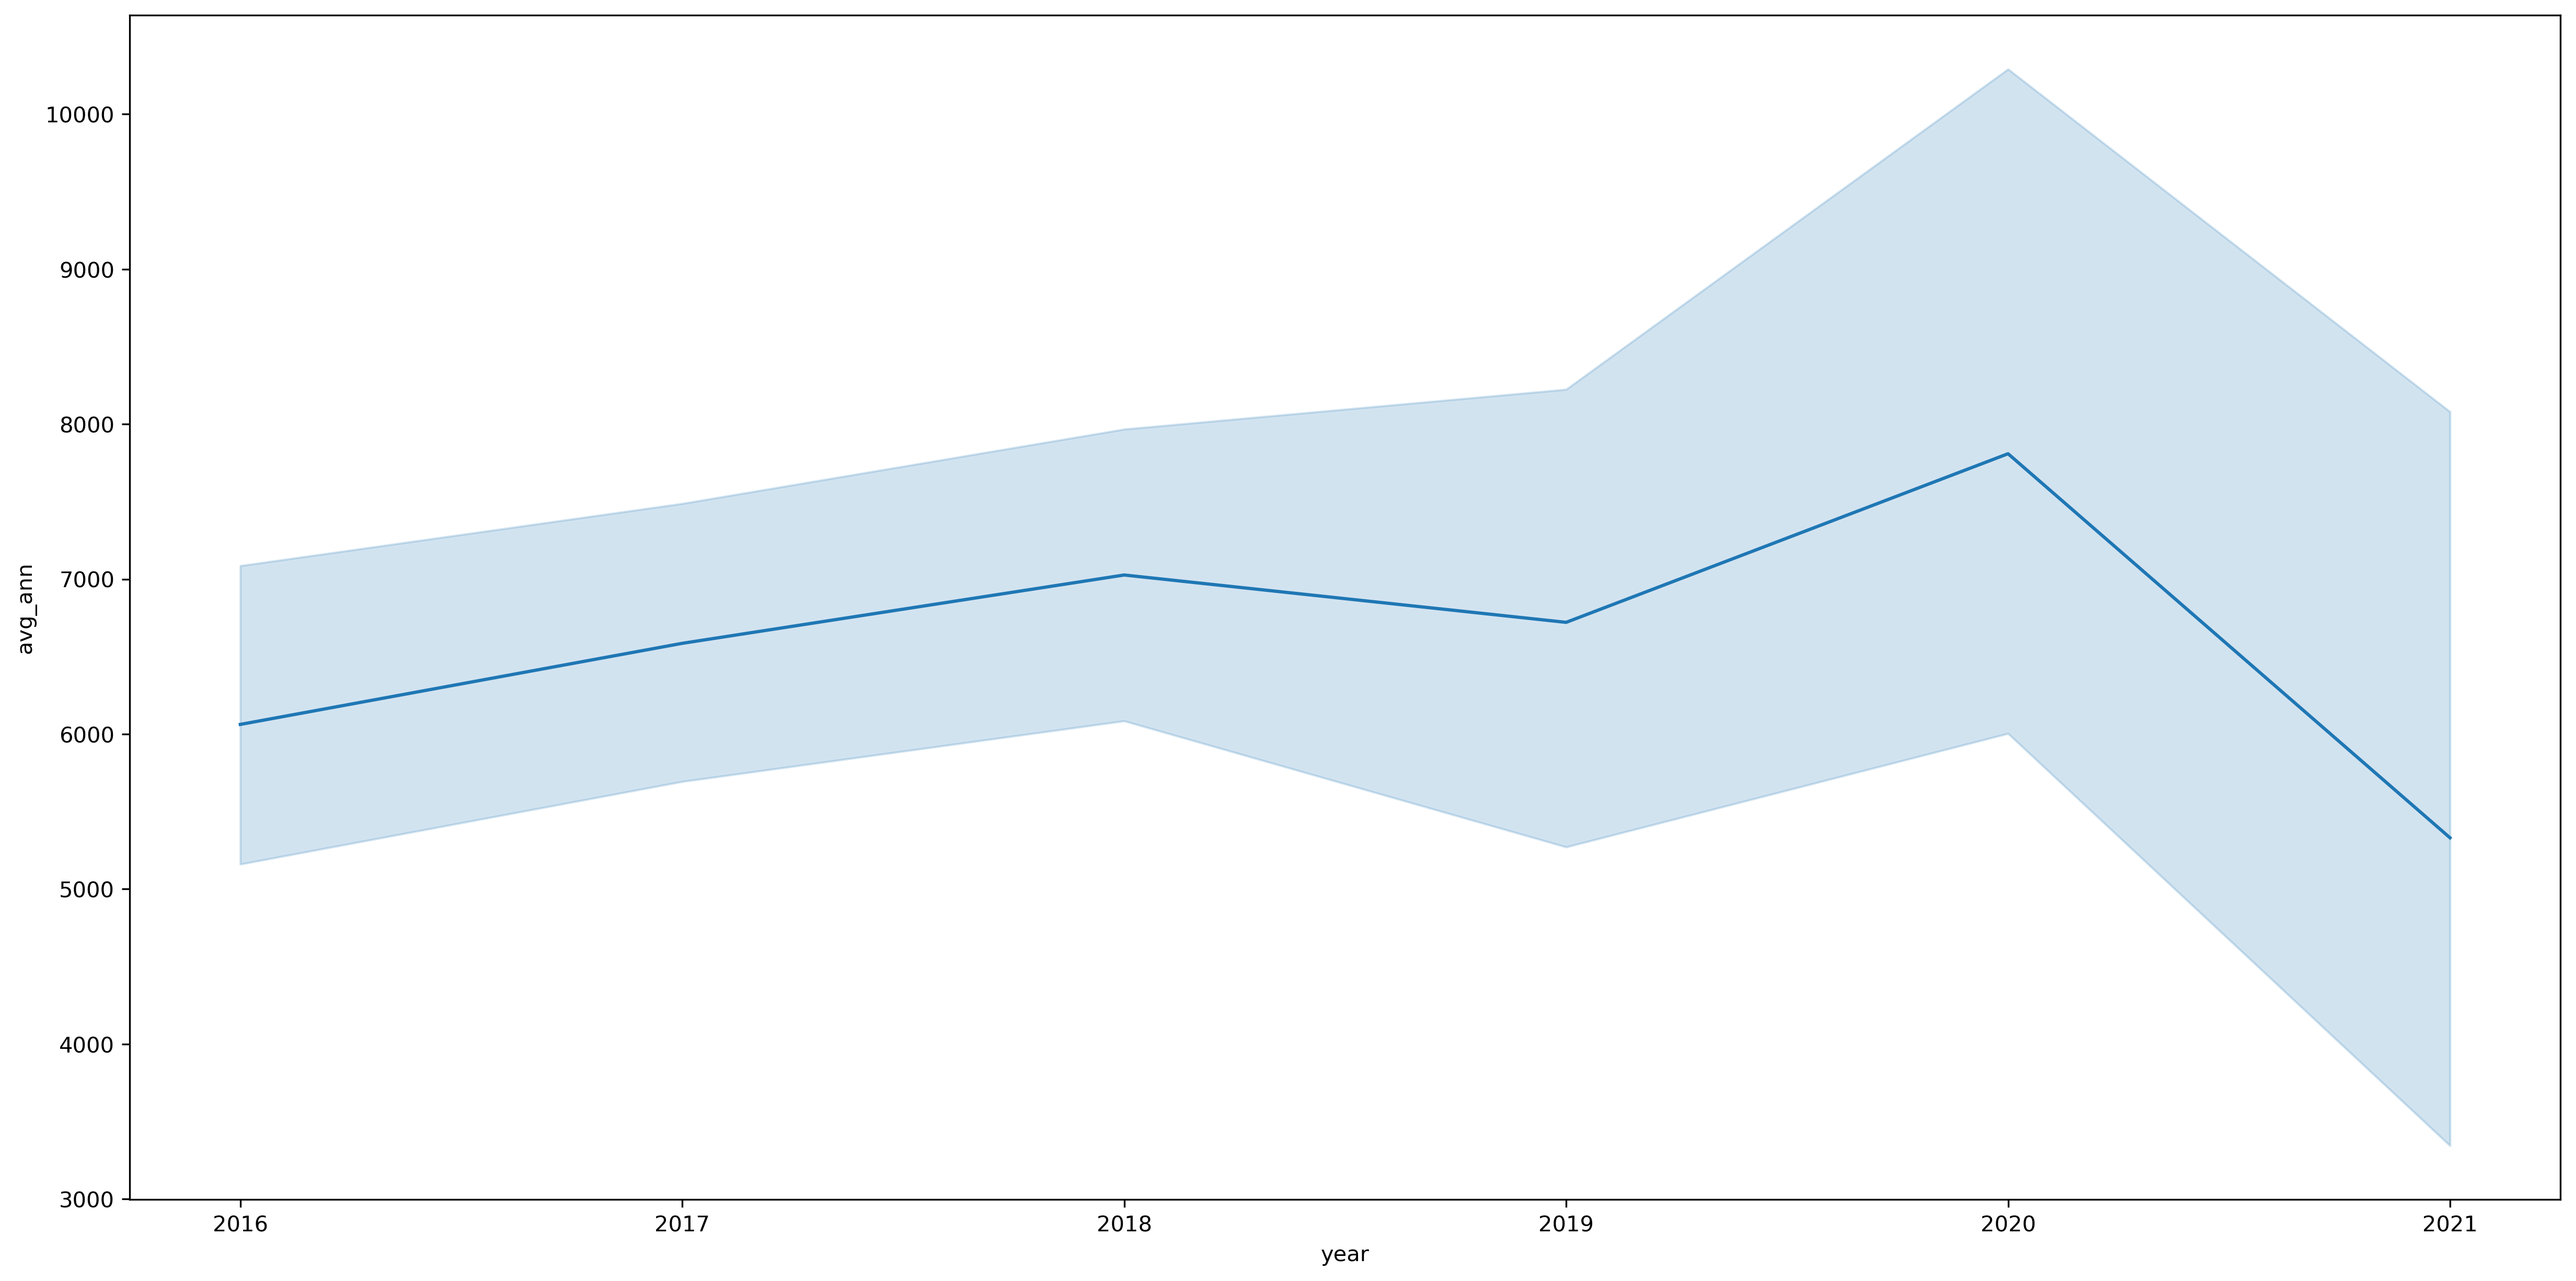

In [185]:
plt.figure(figsize = (20, 10), dpi=300)
sns.lineplot(data = df_no_na, x='year', y='avg_ann')
plt.savefig('average_mileage_covid.png')

In [186]:
df_no_na['registration'].nunique()

336